# Using PCA to study the Ising model phase transition

Notebook based on the paper:

**Discovering phases, phase transitions, and crossovers through unsupervised machine learning: A critical examination.** ([Link](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.95.062122)) 

In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import k_means

#### Load HDF5 utils

In [2]:
def print_name(name):
    print(name)

In [3]:
def get_dataset_paths(folder, data):
    
    sub_folders = []
    data[folder].visit(sub_folders.append)
    
    path = []
    
    for sub_folder in sub_folders:
        path.append(folder + '/' + sub_folder)
    
    return path[1::2]

#### Open file and metadata

In [4]:
# Read only (r), read and write (r+)
data = h5py.File('Data/ising_conf-ener.h5', 'r')

In [5]:
# Read attributes, thery are almost the same for all folders.
data_attrs = [x for x in data['L=60'].attrs]

In [6]:
# Main folder name (L=60,90,120)
main_folder = 'L=60'

# All lattice sizes
lattice_size = data[main_folder].attrs['Lattice Size']

# All temperatures in the main folder
temperatures = data[main_folder].attrs['Temperatures']

# Paths to the datasets in main folder
dataset_paths = get_dataset_paths(main_folder, data)

# Monte Carlo steps
mc_steps = np.int32(data[main_folder].attrs['Monte Carlo Steps'])


#### Building the dataset

In [7]:
# Getting the paths to the datasets. Discarding the last four will make
# the dataset more symmetric that is thirteen before and after the critical temperature.
dataset_paths = dataset_paths[:-4]

In [8]:
# Number of samples get from each dataset.
dataset_size = np.int32(mc_steps)

# Number of folders or dataset to be used.
folders_number = len(dataset_paths)

# Initialising an array to store all data.
dataset = np.zeros((folders_number * dataset_size, lattice_size**2), dtype=np.int32)

# Copying the data to the dataset array.
for i, dataset_path in enumerate(dataset_paths):
    dataset[i*(dataset_size):(i+1)*(dataset_size), :] = data[dataset_path]['Configuration'][0,0:dataset_size,:]

#### Applying PCA

In [9]:
# Usually, to use PCA it is necessary rescale the dataset,
# but I don't think this will be necessary for the Ising,
# we already have only to values (-1,1). 

#dataset = dataset - dataset.mean()

In [10]:
# Create an array to store the temperatures values from each sample.
temp_val = np.zeros((folders_number * dataset_size), dtype=np.float32)

# Fill temp_val with temperatures.
for i, t in enumerate(temperatures):
    temp_val[i * dataset_size:(i + 1) * dataset_size] = t
    
# Creating an array with index chosen randomly from all the samples.
rand = np.random.choice(dataset.shape[0], size=5000, replace=False) #8000

# Select random samples.
tval = temp_val[rand]
dataset = dataset[rand]

In [11]:
# PCA
pca = PCA()
XPCA = pca.fit_transform(dataset)

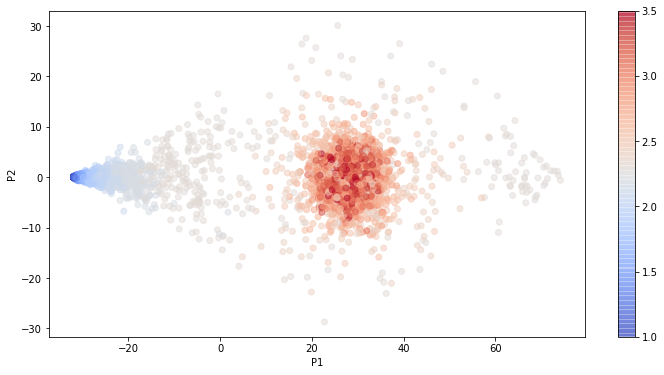

In [12]:
# Plot first and second principal component.

plt.figure(figsize=[12,6])

plt.scatter(XPCA[:,0], XPCA[:,1], c=tval, cmap='coolwarm', alpha=0.5)

plt.colorbar()
plt.ylabel('P2')
plt.xlabel('P1')

plt.show()

> This plot should be symmetrical indicating two possible ground state configuration all spins up or down. I think the main problem here is how my data was generated. I runned only one simulation with single spin flip, so it probabilly got stuck at configurations with all spins down. This problem will be solved if one use a cluster algorithm like Wolff or generates the data starting the simulations with differents initial configurations. 

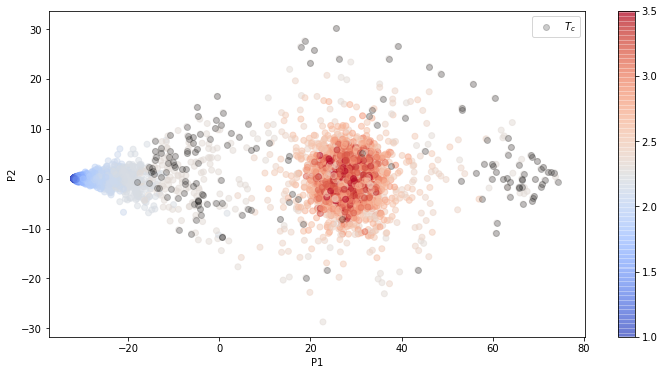

In [13]:
# Plot first and second principal component highlighting 
# critical temperature samples (Black).

plt.figure(figsize=[12,6])

plt.scatter(XPCA[:,0], XPCA[:,1], c=tval, cmap='coolwarm', alpha=0.5)

plt.colorbar()
plt.ylabel('P2')
plt.xlabel('P1')

plt.scatter(XPCA[tval == 2.2844348,0], XPCA[tval == 2.2844348,1], c='black', alpha=0.2, label=r'$T_c$')
plt.legend()

plt.show()

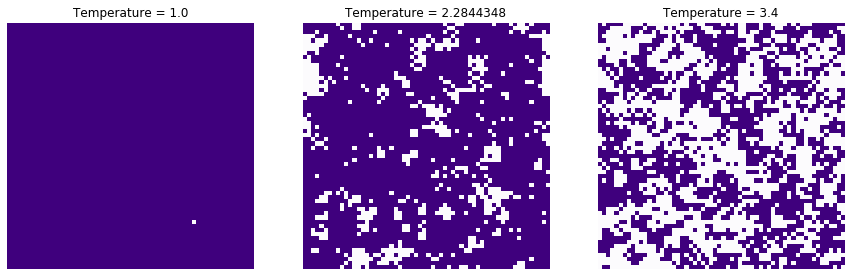

In [14]:
# Example of three configuration at low, critical and high temperatures.

t1 = np.where(tval == 1)[0]
t2 = np.where(tval == 2.2844348)[0]
t3 = np.where(tval == 3.4)[0]

vmin=np.min(dataset)
vmax=np.max(dataset)

plt.figure(figsize=[15,6])

plt.subplot(131)
plt.imshow(np.reshape(np.reshape(dataset[t1[0], :], (1, lattice_size**2)), (lattice_size, lattice_size)),
           origin='lower', cmap='Purples', vmin=vmin, vmax=vmax)

plt.title('Temperature = ' + str(tval[t1[0]]))
plt.axis(False)

plt.subplot(132)
plt.imshow(np.reshape(np.reshape(dataset[t2[0], :], (1, lattice_size**2)), (lattice_size, lattice_size)),
           origin='lower', cmap='Purples', vmin=vmin, vmax=vmax)

plt.title('Temperature = ' + str(tval[t2[0]]))
plt.axis(False)

plt.subplot(133)
plt.imshow(np.reshape(np.reshape(dataset[t3[0], :], (1, lattice_size**2)), (lattice_size, lattice_size)),
           origin='lower', cmap='Purples', vmin=vmin, vmax=vmax)

plt.title('Temperature = ' + str(tval[t3[0]]))
plt.axis(False)

plt.show()

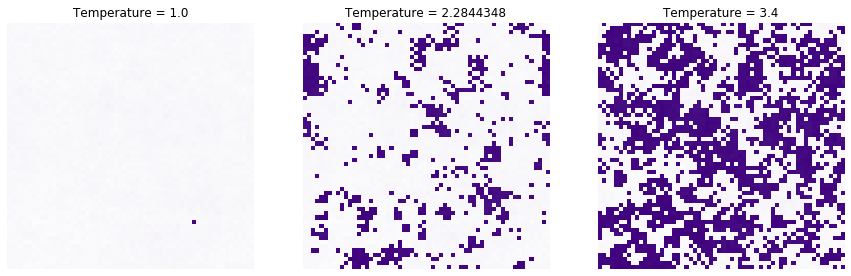

In [15]:
# Example of three configuration multiplied by the first principal
# component at low, critical and high temperatures.

t1 = np.where(tval == 1)[0]
t2 = np.where(tval == 2.2844348)[0]
t3 = np.where(tval == 3.4)[0]

plt.figure(figsize=[15,6])

comp = 0

plt.subplot(131)

aux = pca.components_[comp,:] * dataset[t1[0],:]

vmin=-0.017752222432958004
vmax=0.017625443972513137

plt.imshow(np.reshape(np.reshape(aux, (1, lattice_size**2)), (lattice_size, lattice_size)),
           origin='lower', cmap='Purples', vmin=vmin, vmax=vmax)

plt.title('Temperature = ' + str(tval[t1[0]]))
plt.axis(False)

plt.subplot(132)

aux = pca.components_[comp,:] * dataset[t2[0],:]

plt.imshow(np.reshape(np.reshape(aux, (1, lattice_size**2)), (lattice_size, lattice_size)),
           origin='lower', cmap='Purples', vmin=vmin, vmax=vmax)

plt.title('Temperature = ' + str(tval[t2[0]]))
plt.axis(False)

plt.subplot(133)

aux = pca.components_[comp,:] * dataset[t3[0],:]

plt.imshow(np.reshape(np.reshape(aux, (1, lattice_size**2)), (lattice_size, lattice_size)),
           origin='lower', cmap='Purples', vmin=vmin, vmax=vmax)

plt.title('Temperature = ' + str(tval[t3[0]]))
plt.axis(False)

plt.show()

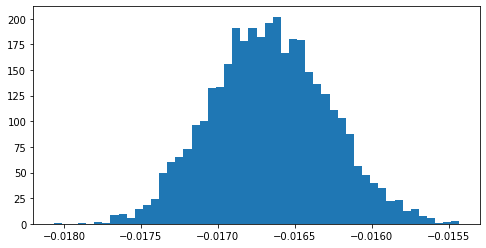

In [16]:
# First principal component distribution.

plt.figure(figsize=[8,4])

plt.hist(pca.components_[0], bins=50)

plt.show()

>The PCA first component vector is essentially constant, this was espected because it corresponds to the magnetization, i.e., the Ising model order parameter.

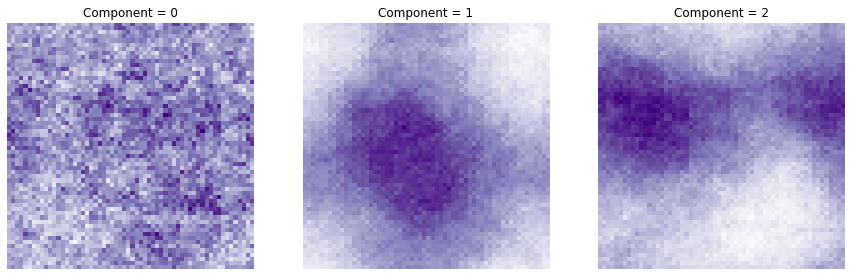

In [17]:
# Plot of three principal component.

plt.figure(figsize=[15,6])

plt.subplot(131)

plt.imshow(np.reshape(np.reshape(pca.components_[0,:] , (1, lattice_size**2)), (lattice_size, lattice_size)),
           origin='lower', cmap='Purples')

plt.title('Component = ' + str(0))
plt.axis(False)

plt.subplot(132)

plt.imshow(np.reshape(np.reshape(pca.components_[1,:] , (1, lattice_size**2)), (lattice_size, lattice_size)),
           origin='lower', cmap='Purples')

plt.title('Component = ' + str(1))
plt.axis(False)

plt.subplot(133)

plt.imshow(np.reshape(np.reshape(pca.components_[2,:] , (1, lattice_size**2)), (lattice_size, lattice_size)),
           origin='lower', cmap='Purples')

plt.title('Component = ' + str(2))
plt.axis(False)

plt.show()

> Second and third component seens to recognize walls domains.

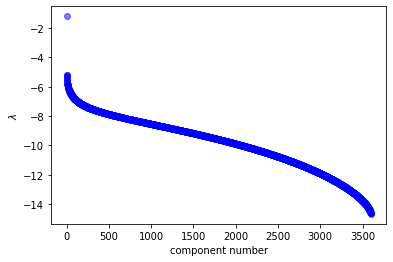

In [18]:
# Eigenvalues ratio.

plt.figure(figsize=[6,4])

plt.plot(np.log(pca.explained_variance_ratio_), 'bo', alpha=0.5)

plt.ylabel(r'$\lambda$')
plt.xlabel('component number')
plt.show()

> The first component describes most of the data information.

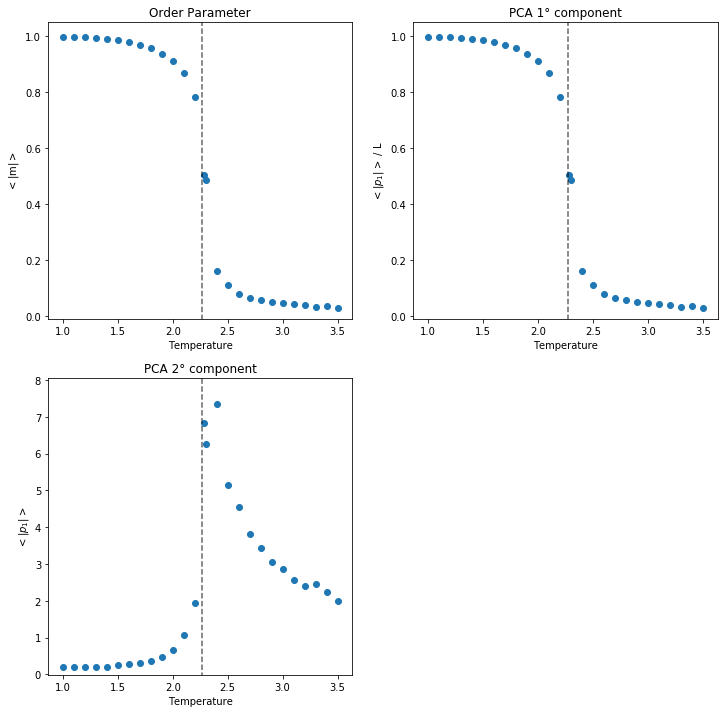

In [19]:
temp = np.unique(tval)

plt.figure(figsize=[12, 12])

plt.subplot(221)
comp = 0

aux = [np.mean(np.abs(np.mean(dataset[tval == t, :], axis=1))) for t in temp]

plt.scatter(temp, aux)
plt.plot(np.repeat(2.2691, 121), np.arange(-0.1, 1.1, 0.01), 'k--', alpha=0.6)
plt.ylim(-0.01, 1.05)
plt.title('Order Parameter')
plt.ylabel(r'$<$|m|$>$')
plt.xlabel('Temperature')

plt.subplot(222)
comp = 0

aux1 = pca.components_[comp]  / np.float32(lattice_size)

aux = [np.mean(np.abs(np.sum(dataset[tval == t, :] * aux1, axis=1))) for t in temp]

plt.scatter(temp, aux)
plt.plot(np.repeat(2.2691, 121), np.arange(-0.1, 1.1, 0.01), 'k--', alpha=0.6)
plt.ylim(-0.01, 1.05)
plt.title('PCA 1° component')
plt.ylabel(r'$<|p_1|>$ / L')
plt.xlabel('Temperature')

plt.subplot(223)
comp = 1

aux1 = pca.components_[comp]

aux = [np.mean(np.abs(np.sum(dataset[tval == t, :] * aux1, axis=1))) for t in temp]

plt.scatter(temp, aux)
plt.plot(np.repeat(2.2691, 820), np.arange(-0.1, 8.1, 0.01), 'k--', alpha=0.6)
plt.ylim(-0.01, 8.05)
plt.title('PCA 2° component')
plt.ylabel(r'$<|p_1|>$')
plt.xlabel('Temperature')

plt.show()

> - LEFT: Plot of the < dataset * first component> at every temperature it looks like the Ising model magnetization .
> - RIGTH: This should be like magnetic susceptibility.

#### Using k_means to split the phases

In [20]:
xcenter, ypred, _ = k_means(XPCA ,n_clusters=3)
cc = np.mean(xcenter, axis=1)

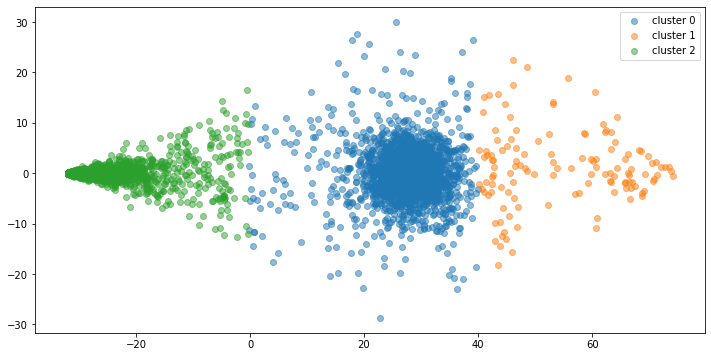

In [21]:
plt.figure(figsize=[12,6])

for pred in np.unique(ypred):
    plt.scatter(XPCA[ypred == pred,0], XPCA[ypred == pred,1], label='cluster %i'%pred, alpha=0.5)

plt.legend()

plt.show()

In [22]:
print('Cluster centers:\n')
for i, c in enumerate(cc):
    print('cluster ' + str(i) + ': ' + str(c))

Cluster centers:

cluster 0: 0.007599329423663162
cluster 1: 0.01418564844588413
cluster 2: -0.007647278206544078


In [23]:
data.close()